## Final Project Submission

Please fill out:
* Student name: **Chris Kamau Wangeci**
* Student pace:  **full time**
* Scheduled project review date/time: **23rd OCT 2023**
* Instructor name: **Mikita Njoroge**


# 1. Importing Libraries

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# conditions and preferences

%matplotlib inline
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)

# 2. Data Import and Auditing

## Data Import

In [58]:
df = pd.read_csv('data\kc_house_data.csv')

## Data View and Data Describing

In [59]:
# Dimension of DataFrame
df.shape

(21597, 21)

In [60]:
# the number of Columns
for column in df.columns:
    print(column)

id
date
price
bedrooms
bathrooms
sqft_living
sqft_lot
floors
waterfront
view
condition
grade
sqft_above
sqft_basement
yr_built
yr_renovated
zipcode
lat
long
sqft_living15
sqft_lot15


In [61]:
# Data Viewing

df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,NO,NONE,Average,11 Excellent,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,NO,NONE,Average,7 Average,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,NO,NaN,Average,7 Average,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,NO,NONE,Average,7 Average,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113
9,3793500160,3/12/2015,323000.0,3,2.50,1890,6560,2.0,NO,NONE,Average,7 Average,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570


In [62]:
# Understanding Data - Total Entries, Number of Columns, Datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [63]:
# Understanding Data and description 

df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,21597.0,4.580474e+09,2.876736e+09,1.000102e+06,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21597.0,5.402966e+05,3.673681e+05,7.800000e+04,3.220000e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,21597.0,3.373200e+00,9.262989e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21597.0,2.115826e+00,7.689843e-01,5.000000e-01,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,21597.0,2.080322e+03,9.181061e+02,3.700000e+02,1.430000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,21597.0,1.509941e+04,4.141264e+04,5.200000e+02,5.040000e+03,7.618000e+03,1.068500e+04,1.651359e+06
floors,21597.0,1.494096e+00,5.396828e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
sqft_above,21597.0,1.788597e+03,8.277598e+02,3.700000e+02,1.190000e+03,1.560000e+03,2.210000e+03,9.410000e+03
yr_built,21597.0,1.971000e+03,2.937523e+01,1.900000e+03,1.951000e+03,1.975000e+03,1.997000e+03,2.015000e+03
yr_renovated,17755.0,8.363678e+01,3.999464e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.015000e+03


## Data Quality

In [64]:
# Checking for Missing vales
df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [65]:
# Duplicate Rows
df.duplicated().sum()

0

## Basic Modification of the Data and Data Definition 

In [66]:
# the data description
numerics = ['price','sqft_lot','sqft_lot15','sqft_living','sqft_living15','sqft_above','sqft_basement','lat','long','yr_built','yr_renovated']
categoricals = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade']

In [67]:
# Dropped date and id Columns
df.drop(['id','date', 'zipcode'],axis=1,inplace=True)

# 3. Exploratory Data Analysis 

## Categorical Variables

### understand the value counts

In [68]:
def print_value_counts(dataframe, columns):
    """
    Print the value counts for specified categorical columns in a DataFrame.
    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the data.
    - columns (list): A list of column names to display value counts for.
    """
    for column in columns:
        print(f"Value counts for '{column}':")
        print(dataframe[column].value_counts())
        print("\n\n")

In [69]:
# print value counts for categorical columns
print_value_counts(df, categoricals)

Value counts for 'bedrooms':
3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64



Value counts for 'bathrooms':
2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64



Value counts for 'floors':
1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64



Value counts for 'waterfront':
NO     19075
YES      146
Name: waterfront, dtype: int64



Value counts for 'view':
NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: in

### plot the value counts

In [70]:

def plot_value_counts(dataframe, columns):
    """Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the data.
    - columns (list): A list of column names to plot value counts for.
    """
    # Set the number of rows and columns for subplots
    num_cols = 2
    num_rows = (len(columns) + 1) // 2

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

    for i, column in enumerate(columns):
        row, col = i // num_cols, i % num_cols
        sns.countplot(data=dataframe, x=column, ax=axes[row, col])
        axes[row, col].set_title(f'Value Counts for {column}')
        axes[row, col].set_xlabel(column)
        axes[row, col].set_ylabel('Count')

    # Ensure all subplots are visible
    if len(columns) % 2 != 0:
        fig.delaxes(axes[row, col+1])

    plt.tight_layout()
    plt.show()

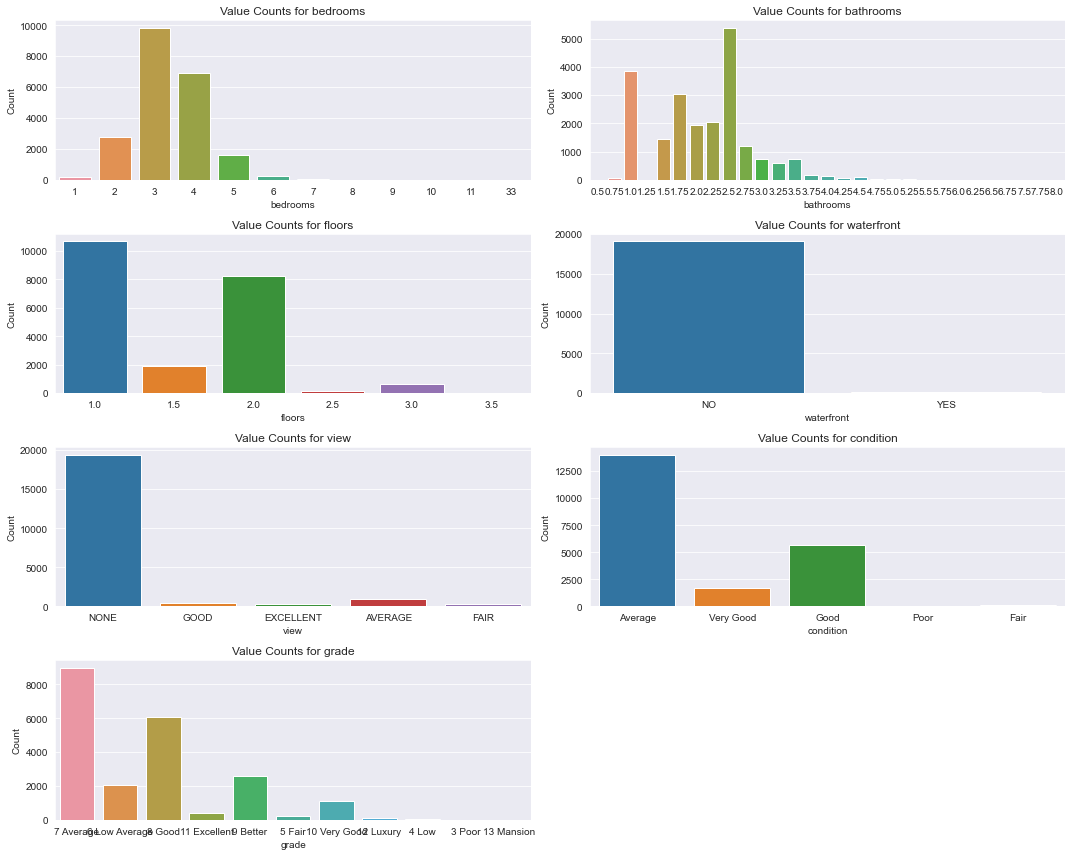

In [71]:
# plot value counts for categorical columns
plot_value_counts(df, categoricals)

In [72]:
df[df['bedrooms'] == 33]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
15856,640000.0,33,1.75,1620,6000,1.0,NO,NONE,Very Good,7 Average,1040,580.0,1947,0.0,47.6878,-122.331,1330,4700


In [73]:
df[df['bedrooms'] != 33]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,NO,NONE,Average,8 Good,1530,0.0,2009,0.0,47.6993,-122.346,1530,1509
21593,400000.0,4,2.50,2310,5813,2.0,NO,NONE,Average,8 Good,2310,0.0,2014,0.0,47.5107,-122.362,1830,7200
21594,402101.0,2,0.75,1020,1350,2.0,NO,NONE,Average,7 Average,1020,0.0,2009,0.0,47.5944,-122.299,1020,2007
21595,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,Average,8 Good,1600,0.0,2004,0.0,47.5345,-122.069,1410,1287


### Understand the Continious data

In [74]:
# Initialize a list to store columns with issues
columns_with_issues = []

for column_name in numerics:
    # Check if the column contains 0 or non-integer, non-float values
    if (df[column_name] == 0).any() or not pd.api.types.is_numeric_dtype(df[column_name]):
        columns_with_issues.append(column_name)

# Print the columns with issues
print("Columns with 0 or non-numeric values:")
for column_name in columns_with_issues:
    print(column_name)

Columns with 0 or non-numeric values:
sqft_basement
yr_renovated


In [75]:
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'], errors='coerce')

filtered_df = df[df['sqft_basement'].isna()]

filtered_df.shape

(454, 18)

In [76]:
df.isnull().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     454
yr_built            0
yr_renovated     3842
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [77]:
df.dropna(inplace=True)

In [78]:
df.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [79]:
df.shape

(15429, 18)

## Correlation Matrix

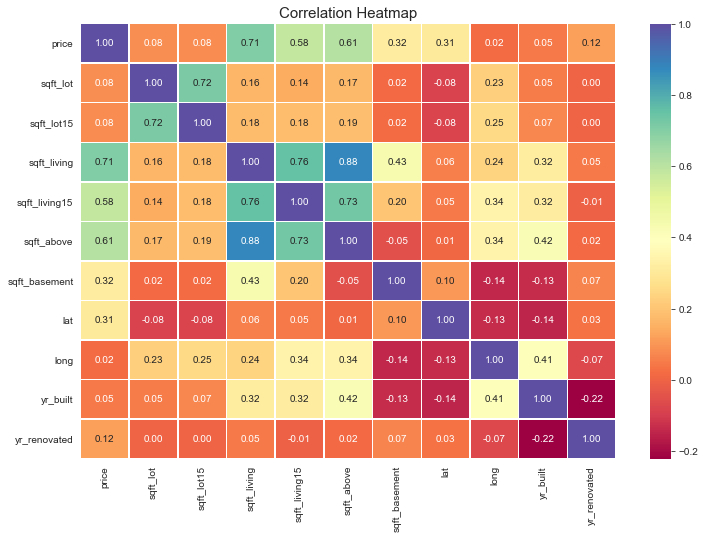

In [80]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerics].corr(), annot=True, cmap='Spectral', linewidths=0.5,fmt=".2f")
plt.title('Correlation Heatmap', fontsize=15)
plt.show()

# 4. Univariate Analysis & Bivariate Analysis

## Creating Function - Numeric Combined Plot

In [81]:
def num_combined_plot(data, x, y):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot the histogram with KDE
    sns.histplot(data=data, x=x, kde=True, ax=axes[0], color='coral')
    
    # Plot the scatterplot with a correlation line
    sns.regplot(data=data, x=x, y=y, ax=axes[1], color='teal', 
                scatter_kws={'edgecolor': 'white'}, line_kws={"color": "coral"})

    # Calculate the correlation coefficient
    corr_coeff = data[[x, y]].corr().iloc[0, 1]

    # Annotate the correlation coefficient on the scatter plot
    axes[1].annotate(f'Correlation : {corr_coeff:.2f}', xy=(0.65, 0.9), xycoords='axes fraction', fontsize=14, color='coral')

    # Adjust plot aesthetics
    sns.despine(bottom=True, left=True)
    axes[0].set(xlabel=f'{x}', ylabel='Frequency', title=f'{x} Distribution')
    axes[1].set(xlabel=f'{x}', ylabel=f'{y}', title=f'{x} vs {y}')
    axes[1].yaxis.set_label_position("right")
    axes[1].yaxis.tick_right()

    plt.show()

## ploting

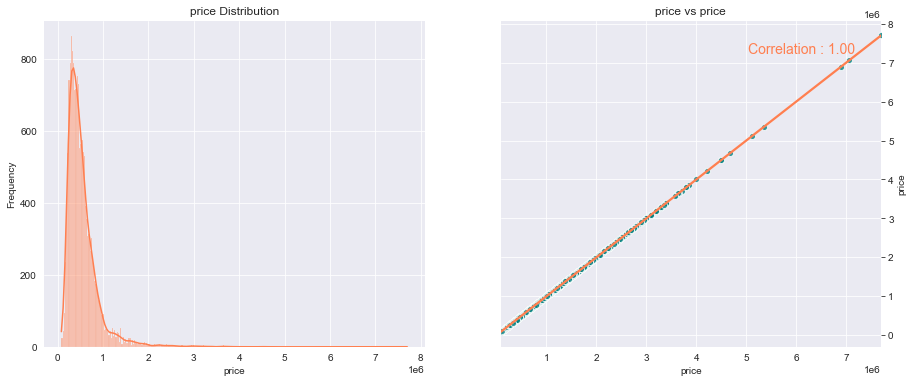

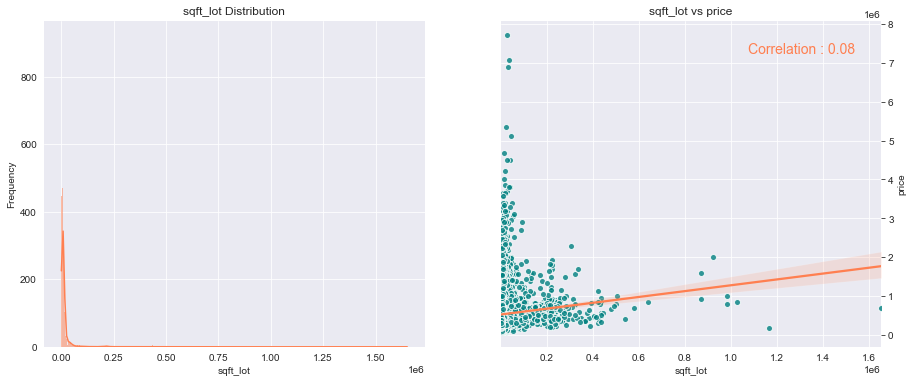

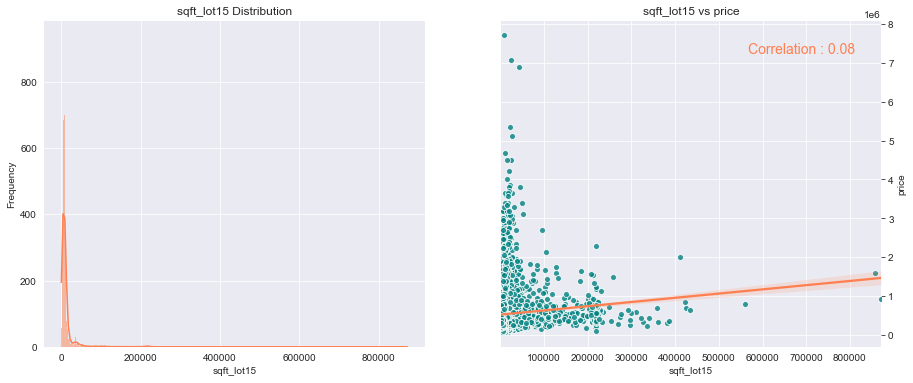

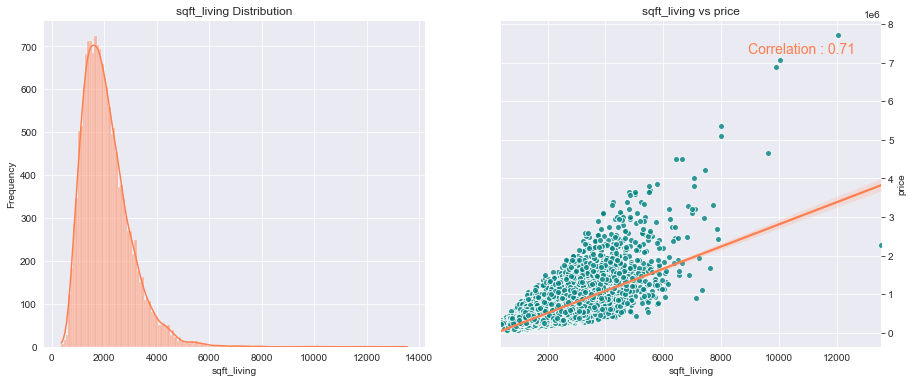

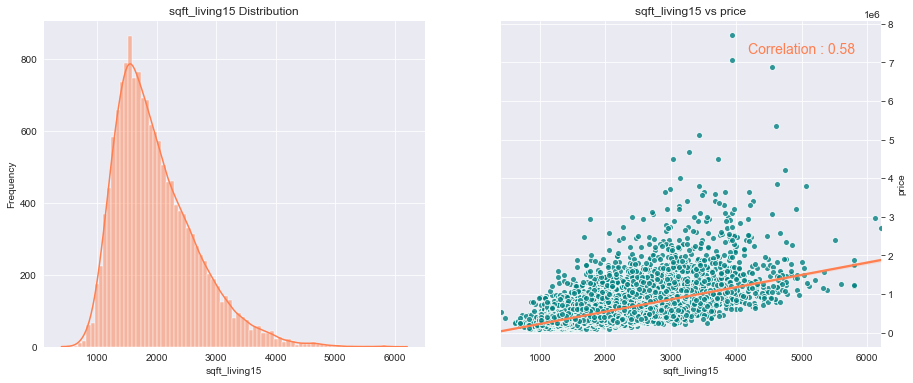

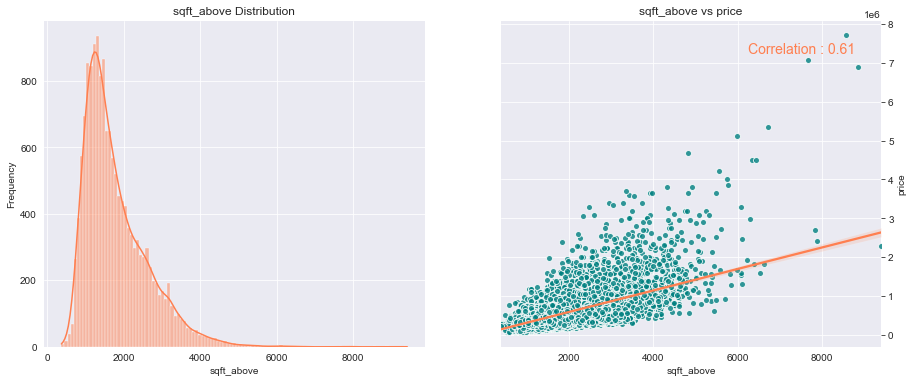

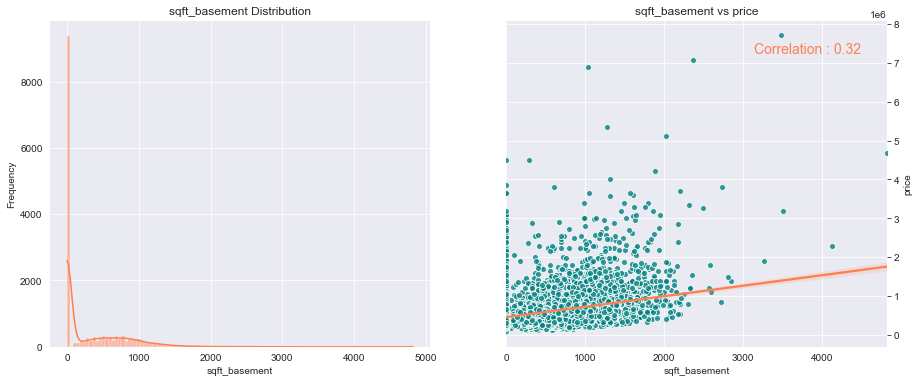

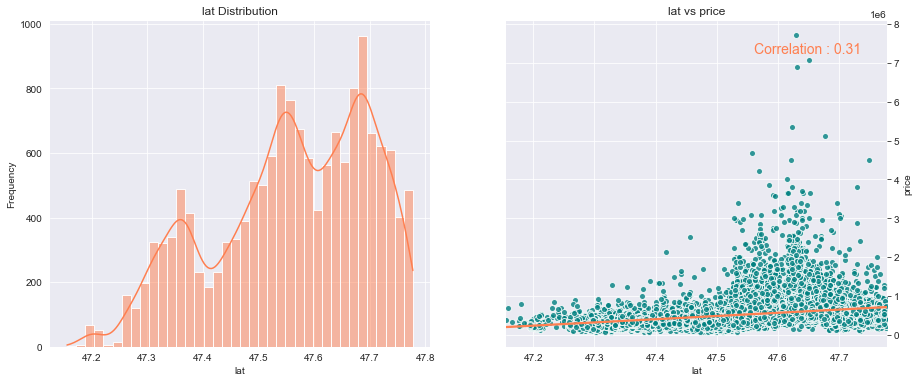

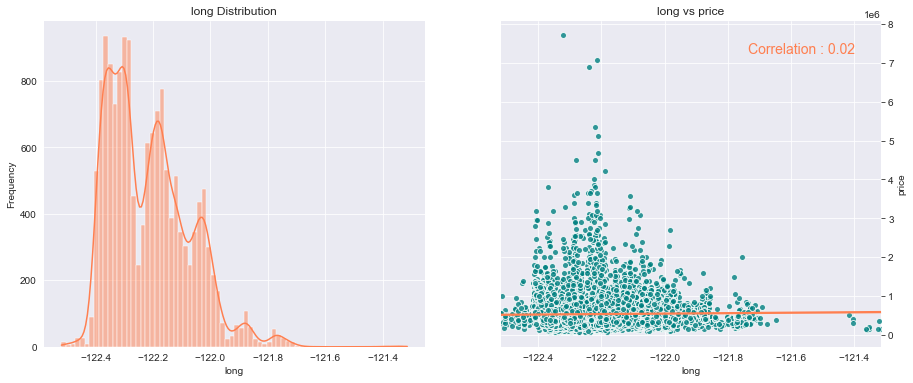

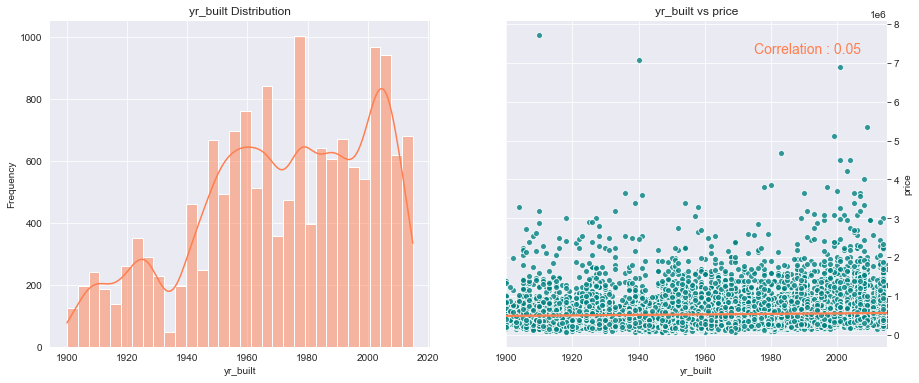

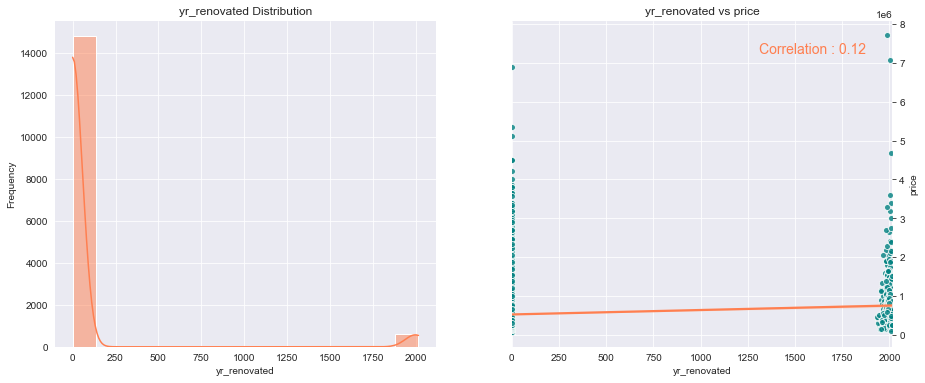

In [82]:
for num in numerics:
    num_combined_plot(df, num, 'price')

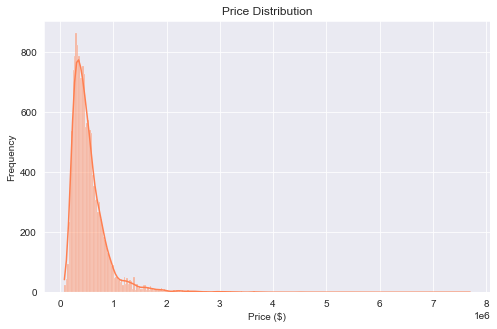

In [83]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='price', kde=True, color='coral')
plt.xlabel('Price ($)')
plt.ylabel('Frequency') 
plt.title('Price Distribution')
plt.show()

## Creating Function - Categoric Combined Plot

In [84]:
def create_subplot_grid(data, x, y):
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: Countplot with percentages
    sns.countplot(data=data, x=x, ax=axes[0], palette='Set2')
    axes[0].set(title=f'{x} Frequency')
    axes[0].tick_params(axis='x', rotation=90)
    axes[0].set_ylabel('Count (%)')

    # Calculate and annotate the percentages
    total = len(data)
    for p in axes[0].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x_ = p.get_x() + p.get_width() / 2
        y_ = p.get_height()
        axes[0].annotate(percentage, (x_, y_), ha='center', va='bottom')

    # Plot 2: Boxplot
    sns.boxplot(data=data, x=x, y=y, ax=axes[1], palette='Set2')
    axes[1].set(title=f'Price vs. {x}')
    axes[1].tick_params(axis='x', rotation=90)

    # Plot 3: Scatterplot with colors based on x
    sns.scatterplot(data=data, x=x, y=y, ax=axes[2], hue=x, palette='Set2')
    axes[2].set(title=f'{y} vs. {x}')
    axes[2].tick_params(axis='x', rotation=90)
    axes[2].yaxis.set_label_position("right")

    # Add a regression line to the scatterplot
    sns.regplot(data=data, x=x, y=y, ax=axes[2], color='coral', scatter=False)
    axes[2].get_legend().remove()

    # Adjust subplot layout
    plt.tight_layout()

    # Display the plots
    plt.show()


### plotting 

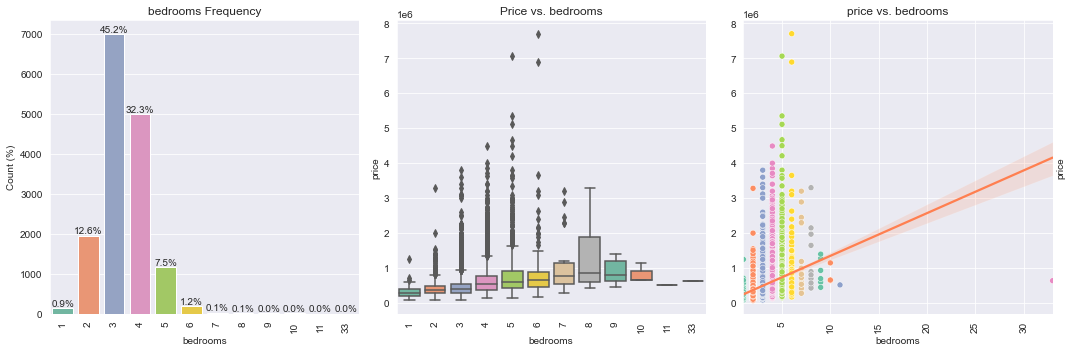

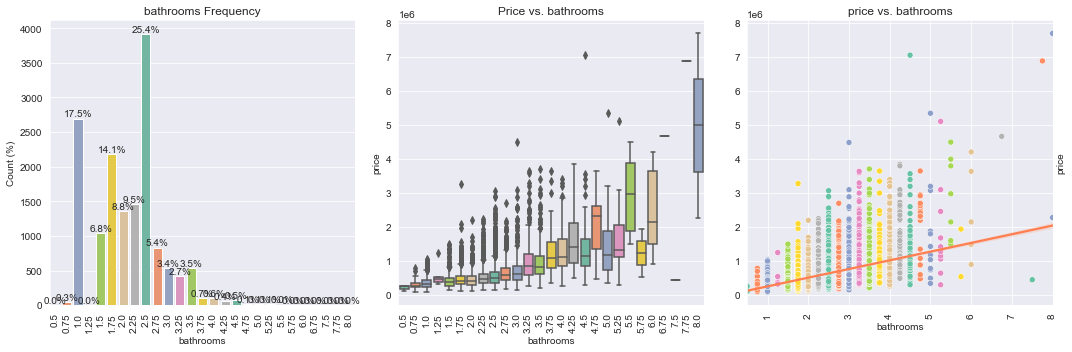

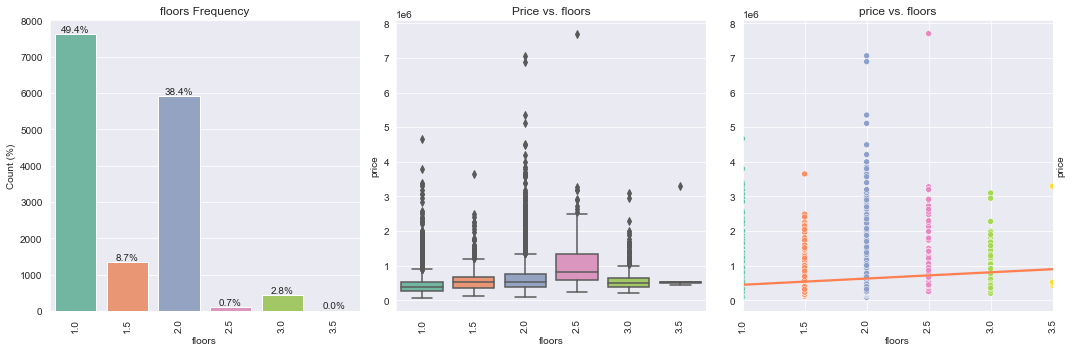

In [85]:
create_subplot_grid(df, 'bedrooms', 'price')
create_subplot_grid(df, 'bathrooms', 'price')
create_subplot_grid(df, 'floors', 'price')


## Yr_renovated - The year of the house’s last renovation

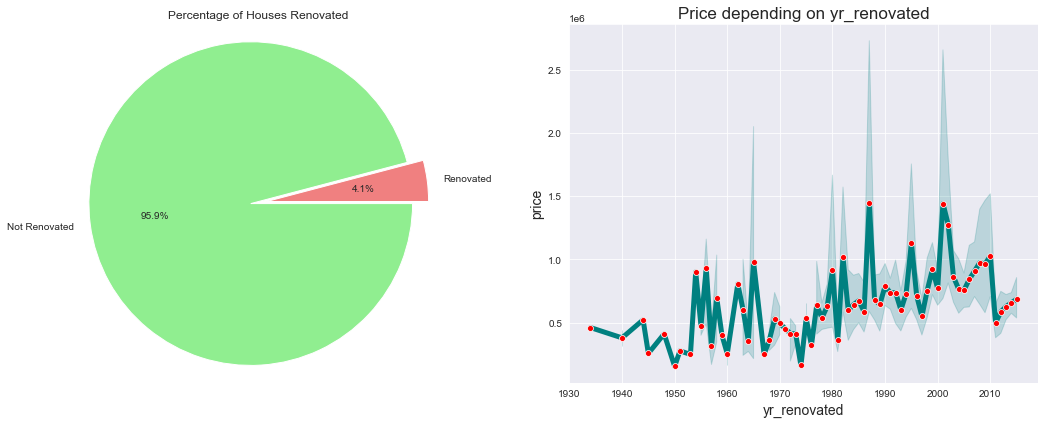

In [86]:
# Count the number of houses that have been renovated (non-zero 'yr_renovated').
renovated_count = len(df[df['yr_renovated'] != 0])

# Calculate the total number of houses.
total_houses = len(df)

# Calculate the percentage of houses that have been renovated.
percentage_renovated = (renovated_count / total_houses) * 100

# Create a pie chart.
labels = ['Renovated', 'Not Renovated']
sizes = [percentage_renovated, 100 - percentage_renovated]
explode = (0.1, 0)  

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=0, explode=explode, colors=['lightcoral', 'lightgreen'])
plt.title('Percentage of Houses Renovated')
plt.axis('equal')

# Create the line plot showing the relationship between price and the year of renovation.
plt.subplot(1, 2, 2)
sns.lineplot(x='yr_renovated', y='price', data=df[df['yr_renovated'] != 0], color='teal', lw=5, marker='o', markerfacecolor='red')
plt.title('Price depending on yr_renovated', fontsize=17)
plt.xlabel('yr_renovated', fontsize=14)
plt.ylabel('price', fontsize=14)

plt.tight_layout()

plt.show()

## Multivariate Analysis

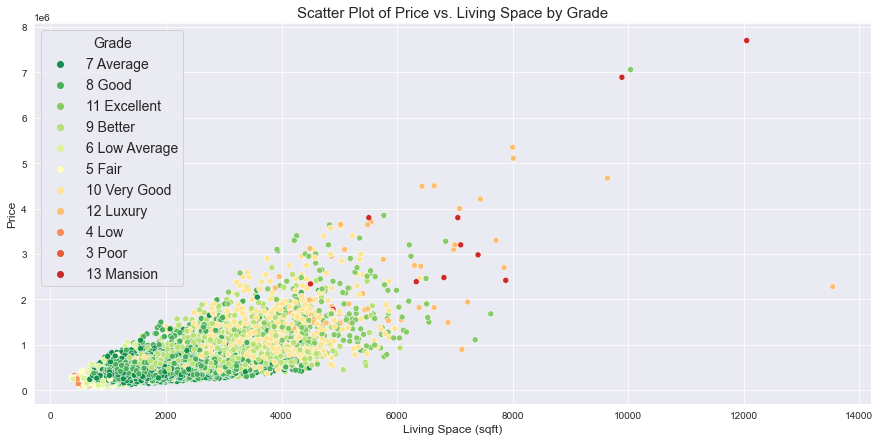

In [87]:
plt.figure(figsize=(15, 7))
sns.scatterplot(data=df, x='sqft_living', y='price', hue='grade', palette='RdYlGn_r')
plt.xlabel('Living Space (sqft)', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Scatter Plot of Price vs. Living Space by Grade', fontsize=15)
plt.legend(title='Grade', fontsize=14, title_fontsize=14)
plt.show()

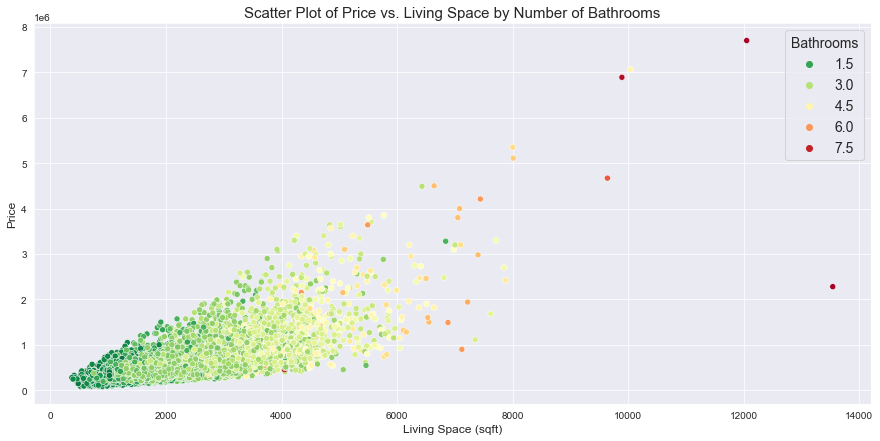

In [88]:
plt.figure(figsize=(15, 7))
sns.scatterplot(data=df, x='sqft_living', y='price', hue='bathrooms', palette='RdYlGn_r')
plt.xlabel('Living Space (sqft)', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Scatter Plot of Price vs. Living Space by Number of Bathrooms', fontsize=15)
plt.legend(title='Bathrooms', fontsize=14, title_fontsize=14)
plt.show()

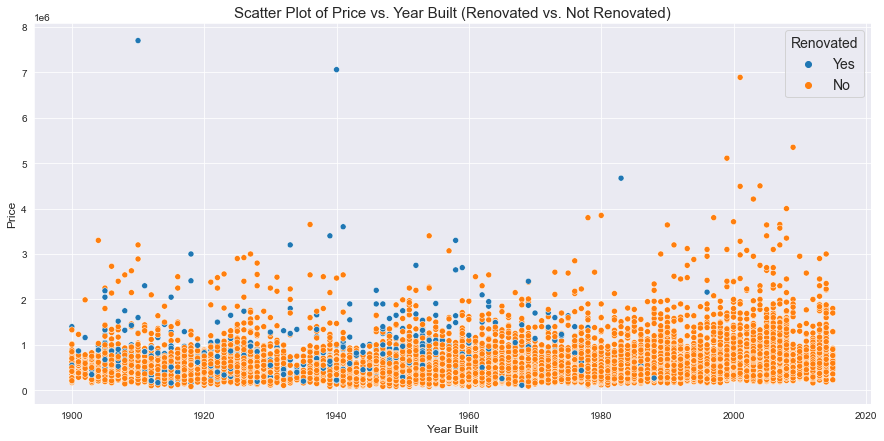

In [89]:
plt.figure(figsize=(15, 7))
sns.scatterplot(data=df, x='yr_built', y='price', hue=df['yr_renovated'].apply(lambda x: 'Yes' if x > 0 else 'No'))
plt.xlabel('Year Built', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Scatter Plot of Price vs. Year Built (Renovated vs. Not Renovated)', fontsize=15)
plt.legend(title='Renovated', fontsize=14, title_fontsize=14)
plt.show()

In [90]:
df['waterfront'].value_counts()

NO     15313
YES      116
Name: waterfront, dtype: int64